In [2]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version
selected_pcs = None # set as default to prevent error in init cell

nb_name = "03_normalization_batch_correction.ipynb"

_compare_version(nb_name)

/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/sctoolbox/utils/jupyter.py:108: UserWarning: The notebook has an older version compared to the installed sctoolbox version (0.10.1 < 0.10.2b0). Some functions may not work!
  warnings.warn(f"The notebook has {ver_dif} version compared to the installed sctoolbox version ({nb_ver} {arrow} {sc_ver}). Some functions may not work!")


# 03 - Normalization and Batch effect correction
<hr style="border:2px solid black"> </hr>

## 1 - Description

Similar to quality control and filtering this step is aimed to prepare the data to facilitate better results in the following analysis steps. However, with normalization and batch effect correction the aim is to refine the data points in a way that

1. comparability between e.g. samples is enhanced
2. the influence of outliers is mitigated
3. variances introduced by technical or otherwise unwanted sources are omitted from the dataset.

Since this reduces the overall noise, the embedding and clustering steps in particular benefit from these adjustments.

________

## 2 - Setup

In [1]:
import sctoolbox
import sctoolbox.tools as tools
import sctoolbox.plotting as pl
import sctoolbox.utils as utils
import scanpy as sc
import pandas as pd

sctoolbox.settings.settings_from_config("config.yaml", key="03")

sc.set_figure_params(vector_friendly=True, dpi_save=600, scanpy=False)

[WARNING] Log file '../logs/03_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


________

## 3 - Load anndata
Loads the anndata.h5ad from the last notebook and provides a basic overview.

In [9]:
adata = utils.adata.load_h5ad("../../../random_cells.h5ad")
adata = adata[adata.obs['fld-100']]
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: ../adatas/../../../random_cells.h5ad


View of AnnData object with n_obs × n_vars = 1917 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)', 'ontology', 'muon-01-07', 'tc-150', 'fld-100'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'files', 'sctoolbox'

,TN,UM,PP,UQ,CM,file,sample,nucleosome_signal,fld_score,mean_fragment_size,n_fragments,fold_change_promoters_fragments,frip,tsse_score,catlas_ov,cell type,closest Cell Ontology term(s),ontology,muon-01-07,tc-150,fld-100
barcode,,,,,,,,,,,,,,,,,,,,,
AAACTACCAGAAACGGATCAGT,3692.0,3009.0,3004.0,3004.0,69.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.462500,184.560884,137.64,2933.0,0.171838,0.086260,1.208600,False,NaN,NaN,NaN,True,False,True
AAACTACCAGACATAGTGGCGT,5811.0,4812.0,4804.0,4804.0,241.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.458333,117.677077,132.98,4822.0,0.356076,0.091456,0.568560,False,NaN,NaN,NaN,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTGCAGAACAGTG,2995.0,2502.0,2493.0,2493.0,227.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.418182,222.135761,134.31,2325.0,0.372043,0.340645,3.709360,False,NaN,NaN,NaN,False,False,True
TTCCATCCTCTGCTAGCCTATA,1498.0,1140.0,1138.0,1138.0,149.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.500000,132.282873,134.22,1140.0,0.828947,0.169298,0.509529,False,NaN,NaN,NaN,False,False,True


,peak_chr,peak_start,peak_end
name,,,
chr1:10007-10565,chr1,10007,10565
chr1:11182-11364,chr1,11182,11364
...,...,...,...
chrY:56870833-56870955,chrY,56870833,56870955
chrY:56886632-56886906,chrY,56886632,56886906


In [10]:
%bgcolor PowderBlue

# Removal of feature subsets
filter_chrM = True  # True or False; filtering out chrM
filter_xy = True    # True or False; filtering out chrX and chrY

# Highly Variable Features options 
select_highly_variable = True
min_cells = 5 # This one is mandatory
max_cells = None

In [11]:
# update number of cells per feature
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/sctoolbox/tools/highly_variable.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_cells = n_cells[idx_selection]


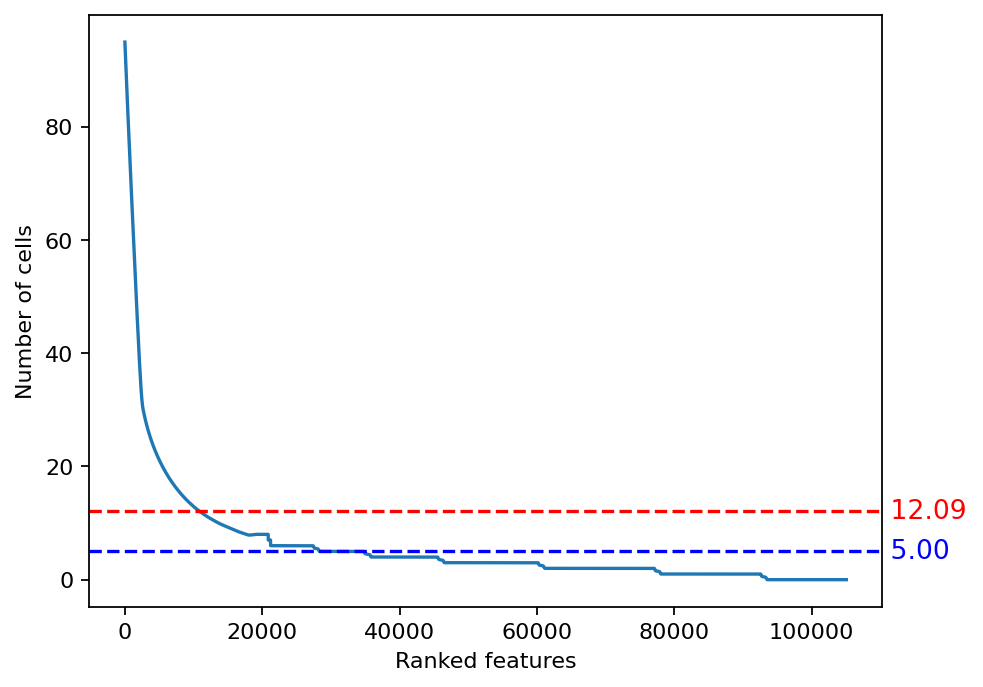

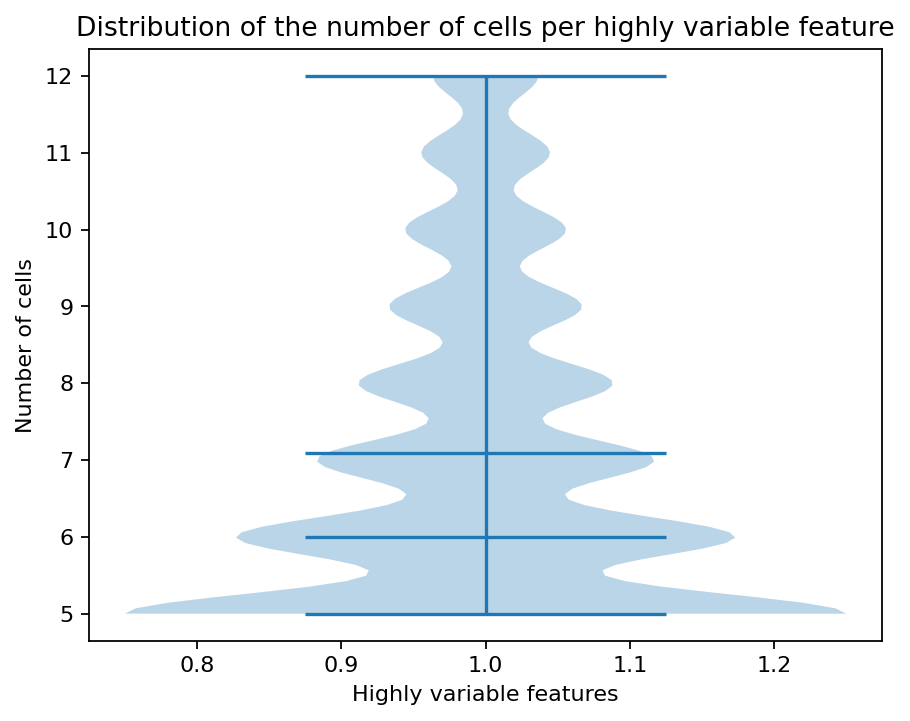

In [12]:
tools.highly_variable.get_variable_features(adata, max_cells, min_cells)
#Number of variable genes selected
adata.var["highly_variable"].sum()
# plot HVF violin
pl.highly_variable.violin_HVF_distribution(adata)

_________

## 4 - General input

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [13]:
%bgcolor PowderBlue

# Choose normalization method
# TF-IDF: dimensionality is reduced by LSI
# Total: dimensionality is reduced by PCA 
norm_method = 'tfidf'  # can be 'tfidf' or 'total'

# Choose if highly variable features should be used
use_highly_variable = True

# Set number of neighbors
n_neighbors = 15

# UMAP related settings 
metacol = 'Ontology'  # some meta-column of interest. See tables above.
n_features = 'n_features'  # column name for the number of features. See tables above.

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "sample"
perform_batch_correction = False
batch_methods = ["bbknn", "harmony"] # "mnn", "scanorama", "combat" 
threads = 8

________________

In [14]:
# Ensure that the batch column is of type category
adata.obs[batch_column] = adata.obs[batch_column].astype(str).astype("category")

____

## 5 - Normalization
<hr style="border:2px solid black"> </hr>

This section performs the selected normalization method followed by a dimension reduction. The counts for each cell are normalized so that all cells have the same number of counts after normalization. This removes imbalances in sequencing depth to make the cells comparable.

The normalization method can be either TF-IDF or total count normalization. Term frequency-inverse document frequencies (TF-IDF), initially adopted by search engines, scores each variable (here open chromatin region) by their importance. It compares the frequency of a variable within a cell against the global occurrence over all cells thus highlighting cell defining variables. On the other hand, total count normalization adjusts the total count of each cell so that all cells have the same total count after normalization. A method frequently used for single cell RNA data.

After normalization a dimension reduction is computed, which depending on the normalization is either latent semantic indexing (LSI) for TF-IDF or principal component analysis (PCA) for total count. However, while differing in details both reduction methods are analogous and thus the following steps are the same independent of the chosen method. Since TF-IDF has been shown to be particularly effective for ATAC-seq data, it is used here as the default method.  
**DOI: [10.1038/nature25981](https://doi.org/10.1038/nature25981)**

In [15]:
# Save raw layer before normalization
adata.layers["raw"] = adata.X.copy()

In [16]:
adata = tools.norm_correct.normalize_adata(adata, norm_method, use_highly_variable=use_highly_variable)

[INFO] Performing TFIDF and LSI...


/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/sctoolbox/tools/norm_correct.py:210: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / matrix.sum(axis=0)).reshape(-1)


___________

## 6 - Dimension reduction and neighbor graph
<hr style="border:2px solid black"> </hr>
Another important property of our data is its high dimensionality. However, this complexity hinders in-depth analysis e.g. the identification of cell states. Thus, dimension reduction algorithms are applied to reduce complexity while simultaneously retaining patterns, a crucial step to enable embedding and clustering. In other words, noise is reduced by removing low variance components as well as components explaining technical or otherwise unwanted factors (e.g. number of active genes, cell cycle, etc.) which also has the benefit of reducing the computational demand. Here the applied algorithms are either Principal Component Analysis (PCA) or Latent Semantic Indexing (LSI). The applied dimension reduction depends on the chosen normalization with total count using PCA and TF-IDF using LSI. For convenience, results of both methods are called principal components (PCs) in the following analysis steps.

**DOI: [10.1038/nmeth.4346](https://doi.org/10.1038/nmeth.4346)**  
**DOI: [10.1038/nature25981](https://doi.org/10.1038/nature25981)**

The following heatmaps and barplots are intended to identify potentially unwanted PCs by showing the PCs in combination with available observations (cell-related metrics) and variables (feature-related metrics). In general, **selected PCs should avoid correlations with metrics**, but the importance of metrics and the stringency of thresholds depends on the experiment and the underlying questions, and therefore requires careful consideration by the analyst.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [17]:
%bgcolor PowderBlue

# number of PCs shown within the heatmap
n_pcs_heatmap = 15

____

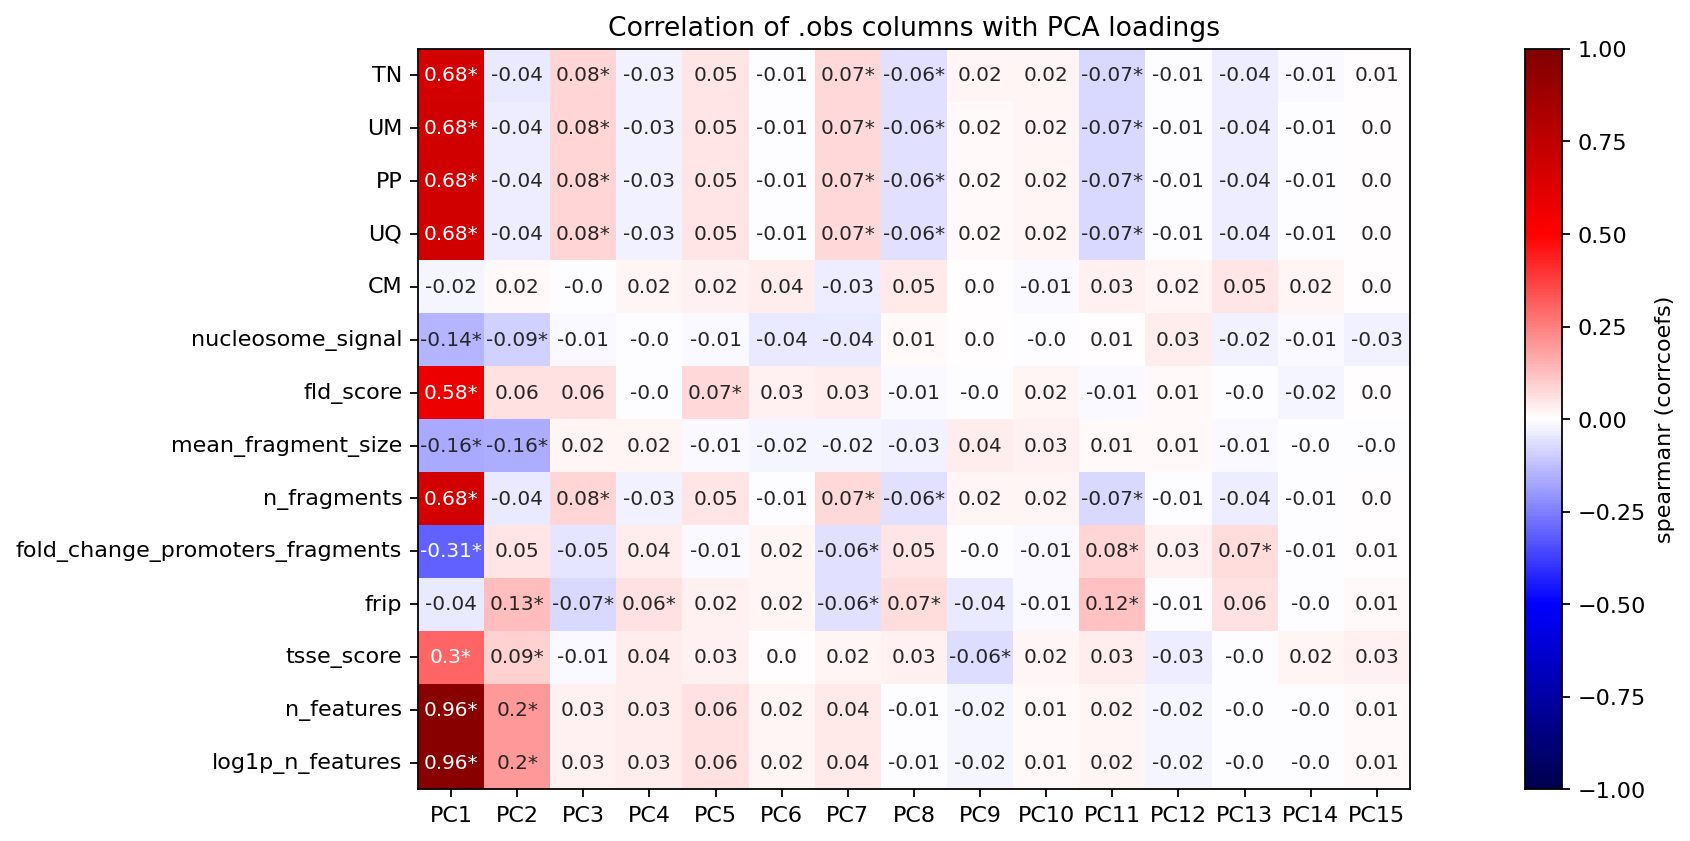

In [18]:
 # PCA correlations with obs variables 
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="obs",
    title="Correlation of .obs columns with PCA loadings",
    save="PCA_correlation_obs.pdf"
)

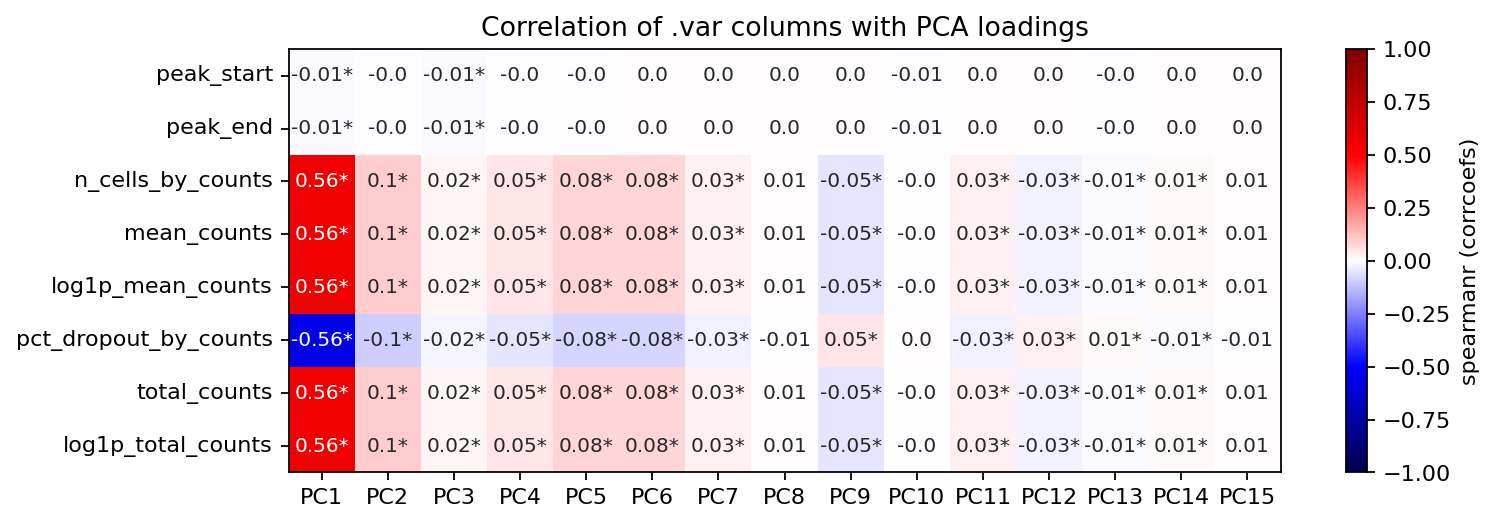

In [19]:
 # PCA correlations with var variables
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="var",
    title="Correlation of .var columns with PCA loadings",
    save="PCA_correlation_var.pdf"
)

_________

### 6.1 - Choose a subset of PCs

In case the above plots showed undesired correlation this section can be used to subset the PCs. The proposed PC subset is displayed as a plot with darker bars representing the selected PCs. Based on the selected `filter_methods`, a vertical and horizontal threshold line is displayed. PCs are filtered if they are below the horizontal threshold (`corr_thresh`) or if they are to the right of the vertical threshold line (`perc_thresh`).

| Parameter | Description | Options |
|:---:|:---|:---|
| subset_pcs | Whether the PCs should be filtered. | `True` or `False` |
| corr_thresh | Highest absolute correlation that is allowed. Will take the maximum correlation for each PC as shown in the heatmap above. | Expects a value between `0-1`. |
| perc_thresh | Top percentile of PCs that should be kept. | A value between `0-100`%. |
| filter_methods | The PCs will be filtered based on the given methods. E.g. for "variance" and "correlation" PCs are filtered on values from both methods and the intersection is used as the final subset. | Any combination of `["variance", "cumulative variance", "correlation"]` |
| basis | Compute correlation based on observations (cells) or variables (genes). | Either `obs` or `var`. |
|ignore_cols| List of column names to ignore for correlation | `None` or a list of column names|

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [20]:
%bgcolor PowderBlue

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.7  # PCs with an absolut correlation above this will be filtered
perc_thresh = 30  # Top percentile of PCs that should be kept
filter_methods = ['cumulative variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var
ignore_cols = []  # List of column names to ignore for correlation

________

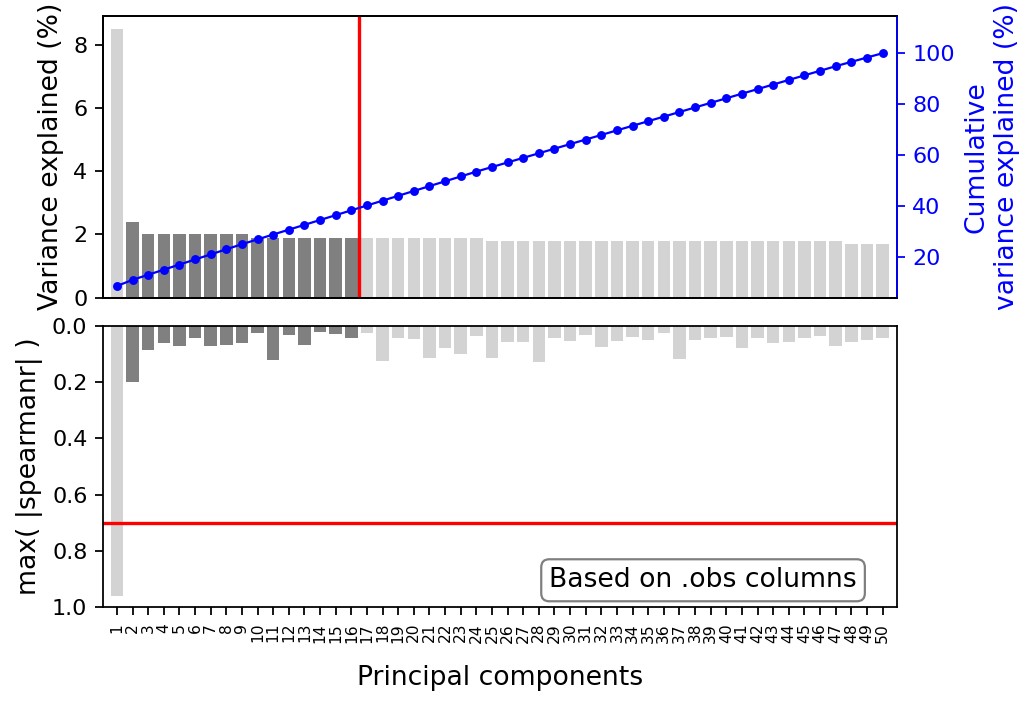

In [21]:
selected_pcs = tools.dim_reduction.propose_pcs(
    anndata=adata,
    how=filter_methods,
    corr_thresh=corr_thresh,
    perc_thresh=perc_thresh,
    corr_kwargs={'method': 'spearmanr', 'which': basis, 'ignore': ignore_cols}
)

# Plot and select number of PCs
_ = pl.embedding.plot_pca_variance(
    adata, 
    save='PCA_variance_proposed_selection.pdf',
    selected=selected_pcs,
    n_pcs=50,
    n_thresh=max(selected_pcs),
    corr_plot='spearmanr',
    corr_thresh=corr_thresh,
    corr_on=basis,
    ignore=ignore_cols
)

In [22]:
f"Proposed principal components: {selected_pcs}"

'Proposed principal components: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]'

Create a final PC-selection by changing the blue cell below:
- Either copy and adjust the proposed list from directly above
- create a custom list of PCs
- or accept the proposed list by not changing the cell below.

**Note: the selection will only be applied when `subset_pcs = True`.**

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [23]:
%bgcolor PowderBlue

final_pc_selection = selected_pcs

-------

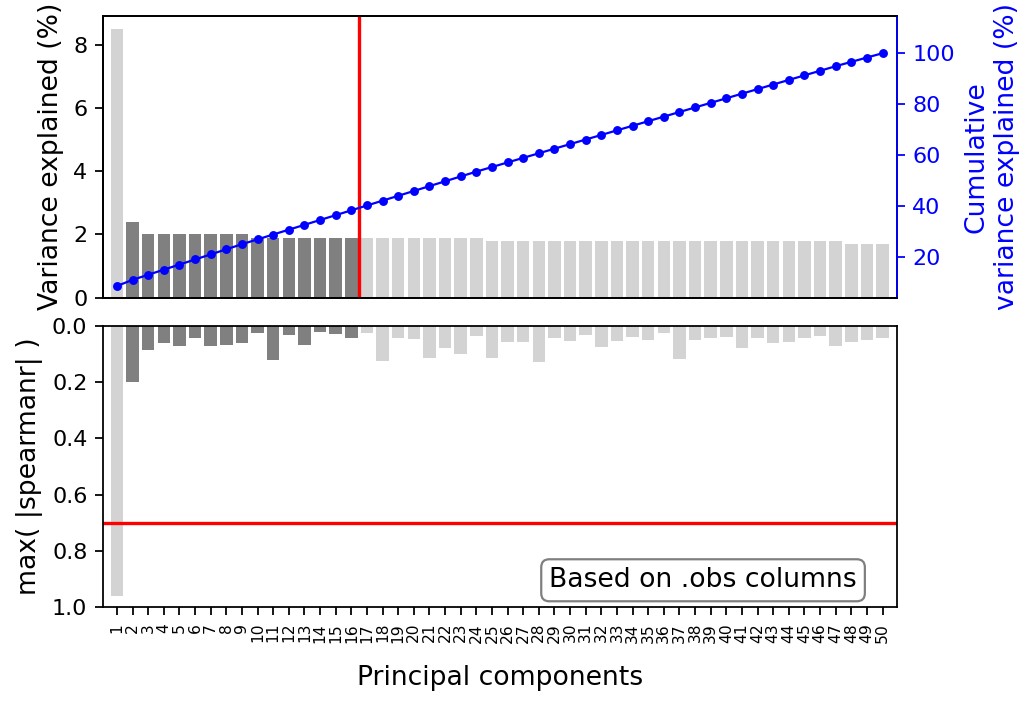

In [24]:
 _ = pl.embedding.plot_pca_variance(
    adata, 
    selected=final_pc_selection if subset_pcs else None,
    save='PCA_variance_final_selection.pdf',
    n_pcs=50,
    n_thresh=max(selected_pcs) if subset_pcs else None,
    corr_plot='spearmanr',
    corr_thresh=corr_thresh if subset_pcs else None,
    corr_on=basis,
    ignore=ignore_cols
)

In [25]:
# Subset the number of pcs if chosen in the parameters
if subset_pcs:
    tools.dim_reduction.subset_PCA(adata, select=final_pc_selection)

___________

### 6.2 - Calculate neighbors
This step construct a graph connecting the cells with their k-nearest-neighbors based on the selected dimension reduction components. This graph represents the structure of the data and thus is used to detect clusters visualized in the UMAP in later steps.

In [26]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', metric='euclidean')

________

## 7 - Batch correction
<hr style="border:2px solid black"> </hr>

Batch effects are variances in the data that are not intended by the experimental design (e.g. technical variance). They can be introduced through various sources. For example, sequencing samples at different timepoints may introduce batch effects. As batch effects could interfere with downstream analysis they are typically removed. However, it can be challenging to identify and correct for batch effects as this is highly dependent on the experimental setup of the dataset.

**DOI: [10.1038/nrg2825](https://doi.org/10.1038/nrg2825)**

There are several batch correction methods available, which may perform differently depending on the data set. Therefore, an overview is provided to compare batch correction methods and select the best performing one. To help in the decision making process, several metrics are shown that can be selected below and a score (LISI) is provided that explains whether the batches are well mixed after applying the correction.

In [ ]:
if perform_batch_correction:
    batch_corrections = tools.norm_correct.wrap_corrections(
        adata, 
        batch_key=batch_column,
        methods=batch_methods
    )
else:
    batch_corrections = {"uncorrected": adata}

__________

### 7.1 - Plot overview of batch corrections

In [ ]:
#Run standard umap for all adatas
tools.embedding.wrap_umap(batch_corrections.values(), threads=threads)

In [ ]:
default_embed_color = [k for k in adata.uns["sctoolbox"]["report"]["qc"]["obs"]["threshold"].keys() if k not in ["before", "after"]] + [batch_column]
default_embed_color

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [7]:
%bgcolor PowderBlue

# Should preliminary clustering be performed?
do_clustering = True  # True or False

# embedding coloring
# choose the metrics shown in the following PCA and UMAP
# accepts adata.obs column names or genes (adata.var.index)
# if empty will use the list shown above
embed_color = [batch_column]

_____________

In [ ]:
# Perform additional clustering if it was chosen
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata, resolution=0.1, flavor="igraph", n_iterations=2)
    (embed_color if embed_color else default_embed_color).append("leiden")
    
# Calculate LISI scores for batch
tools.norm_correct.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

**LISI score:**  
To determine the strength of a batch effect the Local Inverse Simpson's Index (LISI) can be used by measuring the heterogeneity within a local group. Comparing the LISI score between uncorrected data and the batch correction methods can help in deciding which method performed best.  
The LISI score (stored in `adata.obs`) indicates the effective number of different categories represented in the local neighborhood of each cell. If the cells are well-mixed, then we expect the LISI score to be closer to `n` for a dataset with `n` batches.

**DOI: [10.1038/s41592-019-0619-0](https://doi.org/10.1038/s41592-019-0619-0)**

**The higher the LISI score is, the better the batch correction method worked to normalize the batch effect and mix the cells from different batches.**

In [ ]:
# Plot the overview of batch correction methods
adata.obs[batch_column] = adata.obs[batch_column].astype("category")  # ensure that batch column is a category

_ = pl.embedding.anndata_overview(
    batch_corrections,
    color_by=embed_color if embed_color else default_embed_color,
    output=None
)

-----

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [8]:
%bgcolor PowderBlue

# Choose an anndata object to proceed
selected = "bbknn"

In [ ]:
adata_corrected = batch_corrections[selected]

_________

In [ ]:
if not perform_batch_correction and selected != "uncorrected":
    import warnings
    warnings.warn(f"Selected batch correction '{selected}' but batch correction is disabled. Falling back to 'uncorrected'.")
    
    selected = "uncorrected"
elif selected not in batch_corrections:
    raise KeyError(f"'{selected}' is not a key in batch_corrections. Choose one of: {list(batch_corrections.keys())}")

In [ ]:
adata = batch_corrections[selected]

______________

## 8 - Saving adata for the next notebook

In [27]:
adata

AnnData object with n_obs × n_vars = 1917 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)', 'ontology', 'muon-01-07', 'tc-150', 'fld-100', 'n_features', 'log1p_n_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: 'files', 'sctoolbox', 'lsi', 'pca', 'neighbors'
    obsm: 'X_lsi', 'X_pca'
    varm: 'LSI', 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [28]:
#Saving the data
adata_output = "anndata_3.h5ad"
utils.adata.save_h5ad(adata, adata_output)

[INFO] The adata object was saved to: ../adatas/anndata_3.h5ad


In [29]:
sctoolbox.settings.close_logfile()